In [1]:
import numpy as np
import pandas as pd
import seaborn as sns;sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import math
from math import sqrt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

from sklearn import neighbors
import itertools
import plotly.express as px

from itertools import chain
from matplotlib.pyplot import figure

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from collections import Counter
import re
import string

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.pipeline import Pipeline

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [2]:
df=pd.read_csv('train.txt',delimiter=";",header=None,names=['corpus','feeling'])

In [3]:
df

,corpus,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Hipotesis Nula por clase

In [4]:
df.feeling.value_counts(normalize=True)

joy        0.33513
sadness    0.29163
anger      0.13494
fear       0.12106
love       0.08150
surprise   0.03575
Name: feeling, dtype: float64

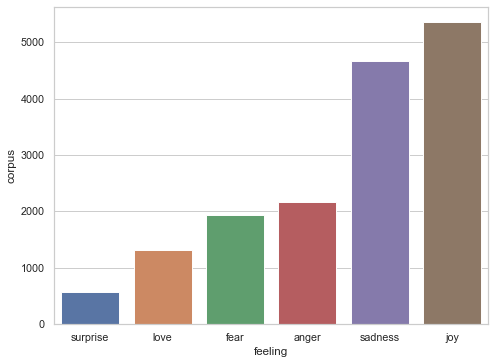

In [5]:
result=df.groupby(by="feeling").count().sort_values(by=['corpus']).reset_index()
fig=figure(figsize=(8, 6), dpi=70)
sns.barplot(x='feeling', y="corpus", data=result, order=result['feeling'])
plt.show()

### Instancio un modelo solo para probar "hipotesis nula"

Probar sobre Test para ver como da un modelo base sin intervencion del texto

### Data Cleaning

In [6]:
# Agrego un diccionario con contracciones y sus extensiones respectivas
contractions = { 
"ain't": "am not",
"aren't": "am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I had",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

### idea: buscar diccionario que reemplace verbos conjugados por verbos infinitvos!

In [7]:
#Agrego las mismas palabras de las stop words pero sin apostrofes (ej: haven't, agrego havent)
stop_words=stopwords.words('english');

hifen =' '.join(stop_words)
hifen = re.sub("'", '', hifen)    
hifen=word_tokenize(hifen)

stop_words.extend(hifen)
stop_words.append('shall')
stop_words.append('im')

In [8]:
#Hermoso código de https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = stop_words
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

clean_lambda = lambda x: clean_text(x)

In [9]:
df['Text_Cleaned'] = df.corpus.apply(clean_lambda)

In [10]:
df

,corpus,feeling,Text_Cleaned
0,i didnt feel humiliated,sadness,"[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,"[brief, time, beanbag, said, anna, feel, like,..."
15996,i am now turning and i feel pathetic that i am...,sadness,"[turning, feel, pathetic, still, waiting, tabl..."
15997,i feel strong and good overall,joy,"[feel, strong, good, overall]"
15998,i feel like this was such a rude comment and i...,anger,"[feel, like, rude, comment, glad]"


In [11]:
def lemmatized_words(text,df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))

In [12]:
lemmatized_words(df.Text_Cleaned,df)

In [13]:
df.head()

,corpus,feeling,Text_Cleaned,lemmatized_text
0,i didnt feel humiliated,sadness,"[feel, humiliated]","[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]","[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...","[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]","[feeling, grouchy]"


In [14]:
df['clean_corpus']=df['lemmatized_text'].apply(lambda x:" ".join(x))

In [15]:
df.head()

,corpus,feeling,Text_Cleaned,lemmatized_text,clean_corpus
0,i didnt feel humiliated,sadness,"[feel, humiliated]","[feel, humiliated]",feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun...","[go, feeling, hopeless, damned, hopeful, aroun...",go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]","[grabbing, minute, post, feel, greedy, wrong]",grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...","[ever, feeling, nostalgic, fireplace, know, st...",ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,"[feeling, grouchy]","[feeling, grouchy]",feeling grouchy


In [16]:
clases=list(df.feeling.unique())
clases=sorted(clases)
clases

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [17]:
#Veo las palabras más frecuentes por feeling

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': 'english',
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

most_common=[]

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['clean_corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    terms=np.array(vectorizer.get_feature_names_out());
    most_common.append(terms[indices[:20]])

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  anger
['feel' 'feeling' 'like' 'feel like' 'really' 'irritable' 'angry' 'cold'
 'irritated' 'fucked' 'greedy' 'time' 'cranky' 'insulted' 'pissed' 'know'
 'little' 'wronged' 'want' 'agitated']

 Clase  fear
['feel' 'feeling' 'like' 'feel like' 'little' 'bit' 'vulnerable' 'know'
 'insecure' 'anxious' 'strange' 'weird' 'terrified' 'nervous' 'afraid'
 'uncertain' 'shaken' 'scared' 'feel vulnerable' 'apprehensive']

 Clase  joy
['feel' 'feeling' 'like' 'feel like' 'really' 'time' 'make' 'pretty' 'day'
 'know' 'good' 'want' 'happy' 'life' 'think' 'little' 'love' 'thing'
 'going' 'today']

 Clase  love
['feel' 'feeling' 'like' 'feel like' 'loving' 'hot' 'horny' 'longing'
 'love' 'passionate' 'caring' 'accepted' 'blessed' 'sympathetic' 'really'
 'delicate' 'loved' 'beloved' 'fond' 'liked']

 Clase  sadness
['feel' 'feeling' 'like' 'feel like' 'know' 'time' 'really' 'little' 'day'
 'bit' 'ive' 'thing' 'want' 'think' 'life' 'make' 'people' 'bad' 'pretty'
 'today']

 Clase  surprise
['fe

In [18]:
new_stop_words=list(chain(*most_common))

In [19]:
#Veo las palabras más repetidas de las palabras más frecuentes por feeling
Counter(new_stop_words).most_common()

[('feel', 6),
 ('feeling', 6),
 ('like', 6),
 ('feel like', 5),
 ('little', 5),
 ('really', 4),
 ('know', 4),
 ('time', 3),
 ('want', 3),
 ('bit', 2),
 ('strange', 2),
 ('weird', 2),
 ('make', 2),
 ('pretty', 2),
 ('day', 2),
 ('life', 2),
 ('think', 2),
 ('love', 2),
 ('thing', 2),
 ('today', 2),
 ('irritable', 1),
 ('angry', 1),
 ('cold', 1),
 ('irritated', 1),
 ('fucked', 1),
 ('greedy', 1),
 ('cranky', 1),
 ('insulted', 1),
 ('pissed', 1),
 ('wronged', 1),
 ('agitated', 1),
 ('vulnerable', 1),
 ('insecure', 1),
 ('anxious', 1),
 ('terrified', 1),
 ('nervous', 1),
 ('afraid', 1),
 ('uncertain', 1),
 ('shaken', 1),
 ('scared', 1),
 ('feel vulnerable', 1),
 ('apprehensive', 1),
 ('good', 1),
 ('happy', 1),
 ('going', 1),
 ('loving', 1),
 ('hot', 1),
 ('horny', 1),
 ('longing', 1),
 ('passionate', 1),
 ('caring', 1),
 ('accepted', 1),
 ('blessed', 1),
 ('sympathetic', 1),
 ('delicate', 1),
 ('loved', 1),
 ('beloved', 1),
 ('fond', 1),
 ('liked', 1),
 ('ive', 1),
 ('people', 1),
 ('bad'

In [20]:
# If more than 2 of the feelings have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(new_stop_words).most_common() if count > 3]
add_stop_words

['feel', 'feeling', 'like', 'feel like', 'little', 'really', 'know']

In [21]:
#Agrego palabras adicionales
stop_words.extend(add_stop_words)
stop_words.append('ive')
stop_words.append('get')
stop_words.append('would')
stop_words.append('feels')
stop_words.append('time')
stop_words.append('still')
stop_words.append('one')
stop_words.append('going')
stop_words.append('bit')
stop_words.append('want')
stop_words.append('today')
stop_words.append('even')
stop_words.append('people')
stop_words.append('think')
stop_words.append('thinking')
stop_words.append('make')
stop_words.append('makes')
stop_words.append('things')
stop_words.append('something')
stop_words.append('could')
stop_words.append('life')
stop_words.append('day')
stop_words.append('saying')
stop_words.append('also')
stop_words.append('much')
stop_words.append('without')
stop_words.append('actually')
stop_words.append('say')
stop_words.append('always')
stop_words.append('feelings')   
stop_words.append('quite')   
stop_words.append('work')   
stop_words.append('way') 
stop_words.append('many') 
stop_words.append('around')
stop_words.append('back')

In [22]:
#Segunda limpieza

clases=['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'];

params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': stop_words, # CAMBIO POR LISTA PERSONALIZADA DEFINIDA EN PASO ANTERIOR
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

for clase in clases:
    X=vectorizer.fit_transform(df[df['feeling']==clase]['corpus']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    terms=np.array(vectorizer.get_feature_names_out());

    print('\n Clase ',clase)
    print(terms[indices[:20]])


 Clase  sadness
['alone' 'disheartened' 'sorry' 'stressed' 'bad' 'listless' 'stupid'
 'discouraged' 'low' 'right' 'gloomy' 'homesick' 'unhappy' 'horrible'
 'defeated' 'depressed' 'sad' 'awkward' 'devastated' 'pretty']

 Clase  anger
['irritable' 'cold' 'angry' 'cranky' 'bothered' 'pissed' 'fucked'
 'annoyed' 'wronged' 'greedy' 'selfish' 'irritated' 'stressed'
 'dissatisfied' 'insulted' 'agitated' 'mad' 'rebellious' 'bitter'
 'jealous']

 Clase  love
['delicate' 'hot' 'nostalgic' 'caring' 'loving' 'naughty' 'passionate'
 'longing' 'horny' 'sympathetic' 'liked' 'loved' 'fond' 'love' 'accepted'
 'beloved' 'blessed' 'sweet' 'supporting' 'supportive']

 Clase  surprise
['overwhelmed' 'funny' 'weird' 'amazed' 'strange' 'curious' 'shocked'
 'surprised' 'amazing' 'impressed' 'dazed' 'stunned' 'remember' 'started'
 'find' 'pretty' 'ludicrous' 'confused' 'dazed confused' 'sure']

 Clase  fear
['insecure' 'anxious' 'weird' 'uncertain' 'scared' 'shaken' 'strange'
 'overwhelmed' 'apprehensive' 'in

### Estaría bueno armar un wordcloud pero no me anda

### Vectorizamos el Dataframe Original

In [23]:
df.head()

,corpus,feeling,Text_Cleaned,lemmatized_text,clean_corpus
0,i didnt feel humiliated,sadness,"[feel, humiliated]","[feel, humiliated]",feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun...","[go, feeling, hopeless, damned, hopeful, aroun...",go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]","[grabbing, minute, post, feel, greedy, wrong]",grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...","[ever, feeling, nostalgic, fireplace, know, st...",ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,"[feeling, grouchy]","[feeling, grouchy]",feeling grouchy


In [24]:
params_tfv = {'max_features': 5000,
             'max_df':0.75,
             'ngram_range': (1, 2),
             'stop_words': stop_words,
             'strip_accents': 'unicode',
             'norm': 'l1',
             'sublinear_tf': True,
             'use_idf': True}

vectorizer=TfidfVectorizer(**params_tfv)

In [25]:
# Vectorizo el dataframe original
df_vect_matrix=vectorizer.fit_transform(df.clean_corpus)
df_vect_matrix.shape

(16000, 5000)

In [26]:
df_vect = pd.DataFrame(df_vect_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df_vect.index = df.index
df_vect

,abandoned,abc,abdomen,ability,abit,able,able find,able go,able help,able move,...,york,young,young woman,younger,youth,youtube,zealand,zero,zombie,zone
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15996,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15997,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
15998,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### Dataset agrupado por Feeling

In [27]:
#Creo un dataframe nuevo donde uno todos los textos por sentimiento

sadness=' '.join(df[df.feeling=='sadness']['clean_corpus'])

anger=' '.join(df[df.feeling=='anger']['clean_corpus'])

love=' '.join(df[df.feeling=='love']['clean_corpus'])

surprise=' '.join(df[df.feeling=='surprise']['clean_corpus'])

fear=' '.join(df[df.feeling=='fear']['clean_corpus'])

joy=' '.join(df[df.feeling=='joy']['clean_corpus'])

d={'sadness':sadness,'anger':anger,'love':love,'surprise':surprise,'fear':fear,'joy':joy}

df_grouped=pd.DataFrame(list(d.items()),columns=['feeling','corpus'])

df_grouped=df_grouped.set_index(['feeling'])

In [28]:
df_grouped.head()

,corpus
feeling,
sadness,feel humiliated go feeling hopeless damned hop...
anger,grabbing minute post feel greedy wrong feeling...
love,ever feeling nostalgic fireplace know still pr...
surprise,ive taking milligram time recommended amount i...
fear,feel confused life teenager jaded year old man...


In [29]:
#Vectorizo el dataset limpio y agrupado

params_cv={'max_features': 5000,'max_df':0.75,'ngram_range': (1, 2),'stop_words': stop_words,'strip_accents': 'unicode'}

cv = CountVectorizer(**params_cv)
data_cv = cv.fit_transform(df_grouped.corpus)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = df_grouped.index
data_dtm

,aa,abandon,abandoned,abandonment,abc,abdomen,abide,abit,able come,able express,...,youthful,youtube,yuuki,zach,zealand,zero,zombie,zone,zoom,zumba
feeling,,,,,,,,,,,,,,,,,,,,,
sadness,1,0,6,1,1,2,0,2,2,0,...,0,0,0,0,1,1,3,0,3,0
anger,1,1,3,1,0,0,1,1,0,0,...,1,0,0,0,0,1,2,0,0,0
love,0,0,0,0,0,0,0,0,0,1,...,0,2,0,1,0,0,0,1,0,1
surprise,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
fear,1,1,1,0,1,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
joy,0,1,0,1,2,1,2,0,1,2,...,2,4,1,2,2,4,0,8,0,2


In [30]:
data=data_dtm.transpose()

In [31]:
# Find the number of unique words that each feeling uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for feeling in data.columns:
    uniques = data[feeling].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(clases, unique_list)), columns=['feeling', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,feeling,unique_words
3,surprise,611
2,love,1431
4,fear,1806
1,anger,2008
0,sadness,3288
5,joy,3695


In [32]:
# Armo un diccionario con la cantidad de elementos por sentimiento
texts_by_feeling=dict(df.feeling.value_counts()) 

# Find the total number of words by feeling (normalizado por la cantidad de elementos)
total_list = []
for feeling in data.columns:
    totals = sum(data[feeling])
    total_list.append(totals)

# Let's add some columns to our dataframe
data_words['total_words'] = total_list
data_words['unique_ratio'] = data_words['unique_words'] / data_words['total_words']

# Sort the dataframe by unique_ratio to see how people talks with each feeling
data_wpm_sort = data_words.sort_values(by='unique_ratio')
data_wpm_sort

,feeling,unique_words,total_words,unique_ratio
5,joy,3695,12533,0.29482
0,sadness,3288,10456,0.31446
1,anger,2008,4733,0.42426
4,fear,1806,3839,0.47044
2,love,1431,2749,0.52055
3,surprise,611,1001,0.61039


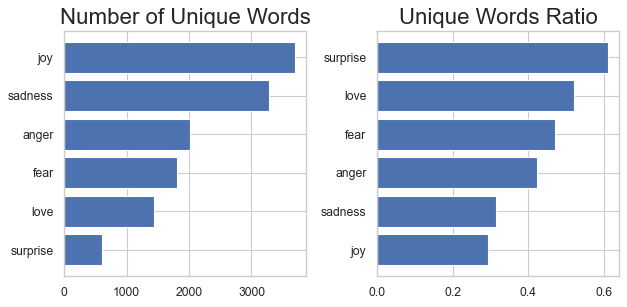

In [33]:
# Let's plot our findings
import numpy as np

figure(figsize=(8, 4), dpi=80)

y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.feeling)
plt.title('Number of Unique Words', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(y_pos, data_wpm_sort.unique_ratio, align='center')
plt.yticks(y_pos, data_wpm_sort.feeling)
plt.title('Unique Words Ratio', fontsize=20)

plt.tight_layout()
plt.show()

Conclusión: Es interesante ver la inversión del orden de sentimientos entre cantidad total de palabras únicas y el ratio de palabras únicas.
Observamos dos grupos bien diferenciados entre sadness y joy (grupo 1) vs el resto de los sentimientos (grupo 2), donde vemos que el primer grupo si bien posee la mayor cantidad de palabras únicas, comparte gran parte del vocabulario para expresarse (unique word ratio) mientras que el segundo posee un vocabulario más rico.

In [34]:
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_grouped['polarity'] = df_grouped['corpus'].apply(pol)
df_grouped['subjectivity'] = df_grouped['corpus'].apply(sub)
df_grouped

,corpus,polarity,subjectivity
feeling,,,
sadness,feel humiliated go feeling hopeless damned hop...,-0.11205,0.58983
anger,grabbing minute post feel greedy wrong feeling...,-0.12007,0.59353
love,ever feeling nostalgic fireplace know still pr...,0.19219,0.61690
surprise,ive taking milligram time recommended amount i...,0.06728,0.63259
fear,feel confused life teenager jaded year old man...,-0.06531,0.56015
joy,petronas year feel petronas performed well mad...,0.25710,0.61008


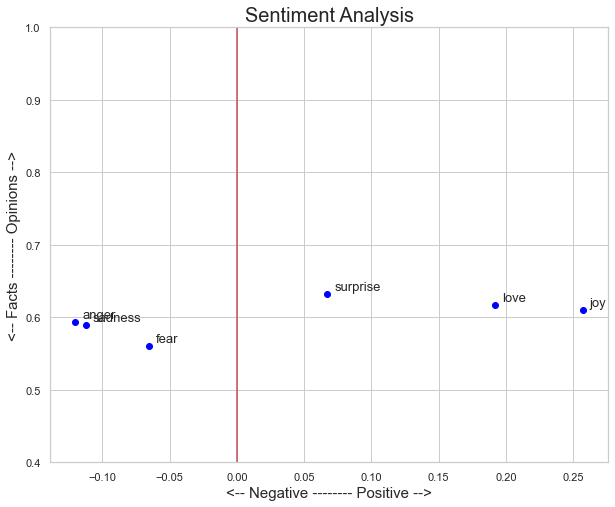

In [35]:
# Let's plot the results

plt.rcParams['figure.figsize'] = [10, 8]

for index, feeling in enumerate(df_grouped.index):
    x = df_grouped.polarity.loc[feeling]
    y = df_grouped.subjectivity.loc[feeling]
    plt.scatter(x, y, color='blue')
    plt.text(x+.005, y+.005, df_grouped.index[index], fontsize=13)
    plt.ylim(0.4,1) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
x1, y1 = [0, 0], [0, 1]
plt.plot(x1, y1, c='r')

plt.show()

Conclusión: Podemos ver que la distribución de los sentimientos de acuerdo a la polaridad es razonable de acuerdo a la realidad.
Una observación muy interesante es la cercanía del enojo con la tristeza. Acaso no todo enojo esconde tristeza? 

## Entrenamiento de modelos

### Dataset de Test

In [36]:
df_test=pd.read_csv('test.txt',delimiter=";",header=None,names=['corpus','feeling'])

In [37]:
df_test['Text_Cleaned'] = df_test.corpus.apply(clean_lambda)

In [38]:
lemmatized_words(df_test.Text_Cleaned,df_test)

In [39]:
df_test['clean_corpus']=df_test['lemmatized_text'].apply(lambda x:" ".join(x))

In [40]:
df_test.head()

,corpus,feeling,Text_Cleaned,lemmatized_text,clean_corpus
0,im feeling rather rotten so im not very ambiti...,sadness,"[rather, rotten, ambitious, right]","[rather, rotten, ambitious, right]",rather rotten ambitious right
1,im updating my blog because i feel shitty,sadness,"[updating, blog, shitty]","[updating, blog, shitty]",updating blog shitty
2,i never make her separate from me because i do...,sadness,"[never, separate, ever, ashamed]","[never, separate, ever, ashamed]",never separate ever ashamed
3,i left with my bouquet of red and yellow tulip...,joy,"[left, bouquet, red, yellow, tulips, arm, slig...","[left, bouquet, red, yellow, tulip, arm, sligh...",left bouquet red yellow tulip arm slightly opt...
4,i was feeling a little vain when i did this one,sadness,[vain],[vain],vain


#### Matriz Sparsa de Test

In [41]:
df_test_matrix=vectorizer.fit_transform(df_test.clean_corpus)
df_test_matrix

<2000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 13978 stored elements in Compressed Sparse Row format>

### Modelo Random Forest con Polarity y Subjetivity

Voy a probar un modelo únicamente con polarity y subjetivity de TextBlob

In [42]:
df_pol=df.copy()

In [43]:
df_pol['polarity'] = df_pol['corpus'].apply(pol)
df_pol['subjectivity'] = df_pol['corpus'].apply(sub)
df_pol

,corpus,feeling,Text_Cleaned,lemmatized_text,clean_corpus,polarity,subjectivity
0,i didnt feel humiliated,sadness,"[feel, humiliated]","[feel, humiliated]",feel humiliated,0.00000,0.00000
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun...","[go, feeling, hopeless, damned, hopeful, aroun...",go feeling hopeless damned hopeful around some...,0.00000,0.00000
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, feel, greedy, wrong]","[grabbing, minute, post, feel, greedy, wrong]",grabbing minute post feel greedy wrong,-0.50000,0.90000
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st...","[ever, feeling, nostalgic, fireplace, know, st...",ever feeling nostalgic fireplace know still pr...,-0.50000,1.00000
4,i am feeling grouchy,anger,"[feeling, grouchy]","[feeling, grouchy]",feeling grouchy,0.00000,0.00000
...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,"[brief, time, beanbag, said, anna, feel, like,...","[brief, time, beanbag, said, anna, feel, like,...",brief time beanbag said anna feel like beaten,0.00000,0.43333
15996,i am now turning and i feel pathetic that i am...,sadness,"[turning, feel, pathetic, still, waiting, tabl...","[turning, feel, pathetic, still, waiting, tabl...",turning feel pathetic still waiting table subb...,-1.00000,1.00000
15997,i feel strong and good overall,joy,"[feel, strong, good, overall]","[feel, strong, good, overall]",feel strong good overall,0.37778,0.44444
15998,i feel like this was such a rude comment and i...,anger,"[feel, like, rude, comment, glad]","[feel, like, rude, comment, glad]",feel like rude comment glad,0.06667,0.70000


In [44]:
params={'max_depth': 10,'class_weight': "balanced"}
clf = RandomForestClassifier(**params)

In [45]:
X=df_pol[['polarity','subjectivity']]
y=df_pol.feeling

In [46]:
clf.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=10)

In [47]:
df_test_rf_pol=df_test.copy()

In [48]:
df_test_rf_pol['polarity'] = df_test_rf_pol['corpus'].apply(pol)
df_test_rf_pol['subjectivity'] = df_test_rf_pol['corpus'].apply(sub)

In [49]:
X_test_rf_pol=df_test_rf_pol[['polarity','subjectivity']]
y_test_rf_pol=df_test_rf_pol.feeling

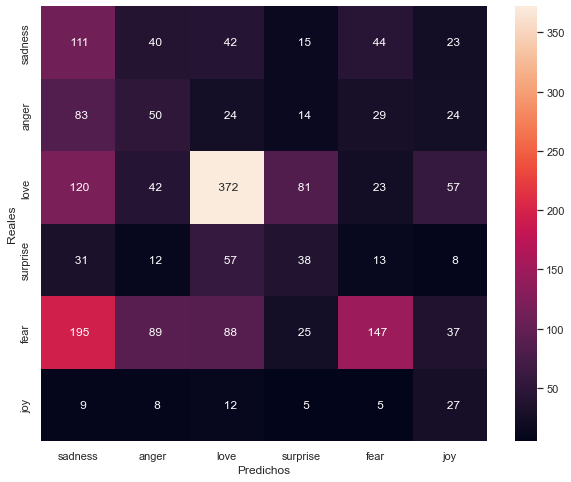

              precision    recall  f1-score   support

       anger     0.2022    0.4036    0.2694       275
        fear     0.2075    0.2232    0.2151       224
         joy     0.6252    0.5353    0.5767       695
        love     0.2135    0.2390    0.2255       159
     sadness     0.5632    0.2530    0.3492       581
    surprise     0.1534    0.4091    0.2231        66

    accuracy                         0.3725      2000
   macro avg     0.3275    0.3439    0.3098      2000
weighted avg     0.4539    0.3725    0.3883      2000



In [50]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=clf.predict(X_test_rf_pol)
sns.heatmap(confusion_matrix(y_test_rf_pol, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_rf_pol, predicciones, digits=4))

### Grid Search para mejorar el accuracy de RF con Polarity y Subjetivity

No lo corri por el tiempo computacional elevado y dado que el modelo previo no ha tenido buenos resultados.

### Modelo MultinomialNB con df_clean

In [51]:
parameters_vect = {
    "max_df": (0.5),
    "strip_accents": ('unicode'), 
    "stop_words": (stop_words),
    'max_features': (5000),
    "ngram_range": (1, 2),  
    'use_idf': (True),
    'sublinear_tf': (True),
    'norm': ('l1')
}

parameters_clf ={
    "alpha": (1.0),
    "fit_prior": (False)
}


pipe = Pipeline(
    [
        ("vect", TfidfVectorizer(**parameters_vect)),
        ("clf", MultinomialNB(**parameters_clf)),
    ]
)

pipe.fit(df.clean_corpus, df.feeling)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, max_features=5000,
                                 ngram_range=(1, 2), norm='l1',
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode', sublinear_tf=True)),
                ('clf', MultinomialNB(fit_prior=False))])

In [52]:
X_test_mnb=df_test['clean_corpus']

In [53]:
y_test_mnb=df_test['feeling']

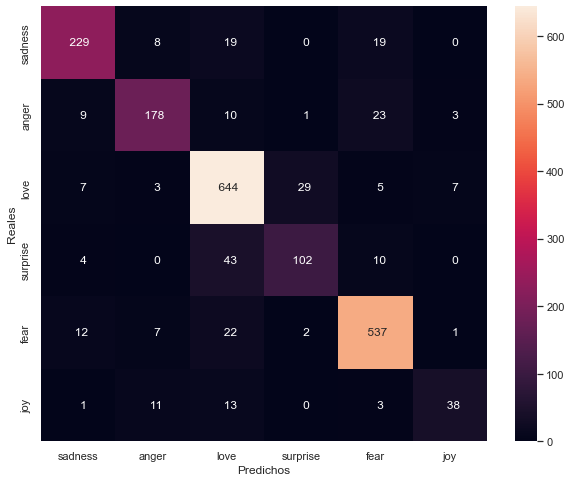

              precision    recall  f1-score   support

       anger     0.8740    0.8327    0.8529       275
        fear     0.8599    0.7946    0.8260       224
         joy     0.8575    0.9266    0.8907       695
        love     0.7612    0.6415    0.6962       159
     sadness     0.8995    0.9243    0.9117       581
    surprise     0.7755    0.5758    0.6609        66

    accuracy                         0.8640      2000
   macro avg     0.8379    0.7826    0.8064      2000
weighted avg     0.8619    0.8640    0.8613      2000



In [54]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=pipe.predict(X_test_mnb)
sns.heatmap(confusion_matrix(y_test_mnb, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_mnb, predicciones, digits=4))

Conclusión Multinomial Naive Bayes. Buena performance. Modelo Elegido.

### Modelo Random Forest con df_clean

Para el RF hay que usar la matriz sparsa convertida en array como features y como y los valores de las clases

In [55]:
X_rf=df_vect_matrix.toarray() # es el dataset original vectorizado
y_rf=df.feeling.values

In [56]:
X_test_rf=df_test_matrix.toarray()
y_test_rf=df_test.feeling.values

In [57]:
param_rf={
 'bootstrap': True,
 'criterion': 'entropy',
 'class_weight':'balanced',
 'n_estimators': 100
}
classifier=RandomForestClassifier(**param_rf)
classifier.fit(X_rf,y_rf)

RandomForestClassifier(class_weight='balanced', criterion='entropy')

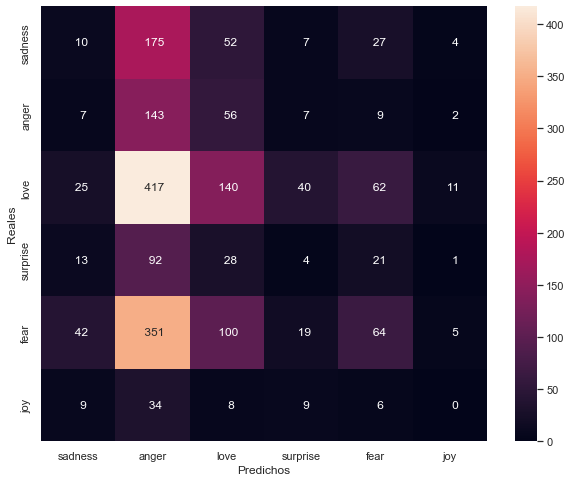

              precision    recall  f1-score   support

       anger     0.0943    0.0364    0.0525       275
        fear     0.1180    0.6384    0.1992       224
         joy     0.3646    0.2014    0.2595       695
        love     0.0465    0.0252    0.0327       159
     sadness     0.3386    0.1102    0.1662       581
    surprise     0.0000    0.0000    0.0000        66

    accuracy                         0.1805      2000
   macro avg     0.1603    0.1686    0.1183      2000
weighted avg     0.2549    0.1805    0.1706      2000



In [58]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=classifier.predict(X_test_rf)
sns.heatmap(confusion_matrix(y_test_rf, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_rf, predicciones, digits=4))

### Grid Search Random Forest con df_clean

no son los mejores hiperparámetros, fue una primera iteración de prueba (probar con más max depth)

In [59]:
param_best_rf={'bootstrap': False, 
               'class_weight': 'balanced_subsample', 
               'criterion': 'gini',
               'max_depth': 8, 
               'max_features': 'auto', 
               'min_samples_leaf': 8,
               'min_samples_split': 5, 
               'n_estimators': 100}

In [60]:
classifier_best=RandomForestClassifier(**param_best_rf)
classifier_best.fit(X_rf,y_rf)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=8, min_samples_leaf=8, min_samples_split=5)

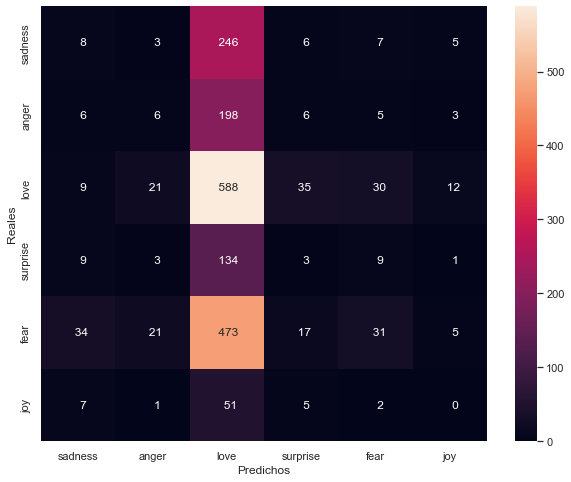

              precision    recall  f1-score   support

       anger     0.1096    0.0291    0.0460       275
        fear     0.1091    0.0268    0.0430       224
         joy     0.3479    0.8460    0.4931       695
        love     0.0417    0.0189    0.0260       159
     sadness     0.3690    0.0534    0.0932       581
    surprise     0.0000    0.0000    0.0000        66

    accuracy                         0.3180      2000
   macro avg     0.1629    0.1624    0.1169      2000
weighted avg     0.2587    0.3180    0.2116      2000



In [61]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=classifier_best.predict(X_test_rf)
sns.heatmap(confusion_matrix(y_test_rf, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_rf, predicciones, digits=4))

Conclusión RF: Vemos que mejoramos el accuracy al predecir casi todo como la clase mayoritaria ('Joy'). Esto demuestra una performance muy pobre. 

### Multinomial Logistic Regression

In [62]:
lr_parameters={'C': 1.0,
               'class_weight': 'balanced',
               'fit_intercept': False,
               'max_iter': 500, 
               'multi_class': 'multinomial', 
               'penalty': 'l2',
               'solver': 'lbfgs'}


In [63]:
lr = LogisticRegression(**lr_parameters)

In [64]:
lr.fit(X_rf,y_rf)

LogisticRegression(class_weight='balanced', fit_intercept=False, max_iter=500,
                   multi_class='multinomial')

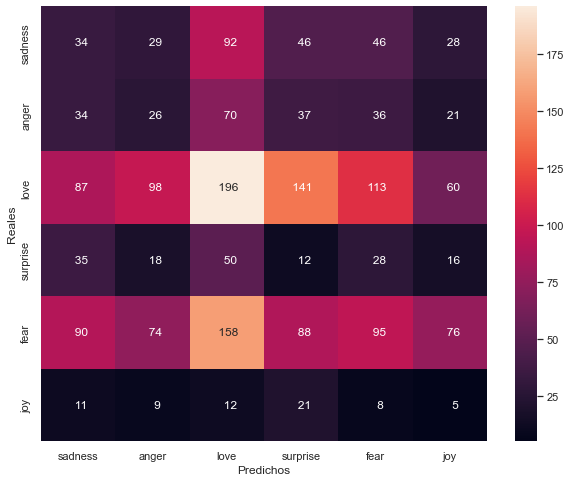

              precision    recall  f1-score   support

       anger     0.1168    0.1236    0.1201       275
        fear     0.1024    0.1161    0.1088       224
         joy     0.3391    0.2820    0.3079       695
        love     0.0348    0.0755    0.0476       159
     sadness     0.2914    0.1635    0.2095       581
    surprise     0.0243    0.0758    0.0368        66

    accuracy                         0.1840      2000
   macro avg     0.1515    0.1394    0.1385      2000
weighted avg     0.2336    0.1840    0.2016      2000



In [66]:
# Calculamos las predicciones y métricas sobre la data de prueba

predicciones=lr.predict(X_test_rf)
sns.heatmap(confusion_matrix(y_test_rf, predicciones), annot=True, fmt='4d',xticklabels=clases, yticklabels=clases)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.show()
print(classification_report(y_test_rf, predicciones, digits=4))

Conclusión Multi Linear Regression: Mala performance. 

### Cosas viejas